In [6]:
!pip install sunpy[all]
!pip install radyn-xtools


  Using cached parfive-2.2.0-py3-none-any.whl.metadata (5.6 kB)
  Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (19 kB)
  Using cached mpl_animators-1.2.4-py3-none-any.whl.metadata (6.4 kB)
  Using cached drms-0.9.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached h5netcdf-1.6.4-py3-none-any.whl.metadata (13 kB)
  Using cached astropy_healpix-1.1.2-cp310-abi3-win_amd64.whl.metadata (4.2 kB)
  Using cached PyAVM-0.9.6-py3-none-any.whl.metadata (5.6 kB)
  Using cached isodate-0.7.2-py3-none-any.whl.metadata (11 kB)
  Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl.metadata (14 kB)
  Using cached requests_file-2.1.0-py2.py3-none-any.whl.metadata (1.7 kB)
  Using cached partd-1.4.2-py3-none-any.whl.metadata (4.6 kB)
  Using cached toolz-1.0.0-py3-none-any.whl.metadata (5.1 kB)
  Using cached donfig-0.8.1.post1-py3-none-any.whl.metadata (5.0 kB)
  Using cached crc32c-2.7.1-cp312-cp312-win_amd64.whl.metadata (7.5 kB)
  Using cached locket-1.0.0-py2.py3-none

In [2]:
import os
from os.path import dirname, join as pjoin
import scipy.io as sio
from scipy.io import readsav
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import glob

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import time_support
from astropy.io import fits

from datetime import datetime, timedelta

import sunpy.map
from sunpy import timeseries as ts
from sunpy.net import Fido
from sunpy.net import attrs as a
from sunpy.coordinates import frames


%matplotlib inline
from scipy import signal
from scipy import stats


from scipy.optimize import curve_fit

import pickle
import math
import scipy.constants as const

from typing import List

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
#folder= "/content/drive/Othercomputers/UofG_Computer/IR/Delay-observations-mid-infrared-channels-in-solar-flare-footpoints"
folder=r"C:\Users\migue\OneDrive - University of Glasgow\IR\Delay-observations-mid-infrared-channels-in-solar-flare-footpoints"

In [8]:
# Colourblind-friendly palette from colour universal design (CUD)
CB = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']


# https://jfly.uni-koeln.de/color/
named_colors = {"black": "#000000",
    "orange": "#e69f00",
    "skyblue": "#56b4e9",
    "bluish green": "#009e73",
    "yellow": "#f0e442",
    "blue": "#0072b2",
    "vermilion": "#d55e00",
    "reddish purple": "#cc79a7",
}
cud_palette = list(named_colors.values())


def cud(n: int = len(cud_palette), start: int = 0) -> List[str]:
    remainder = cud_palette[:start]
    palette = cud_palette[start:] + remainder
    return palette[:n]


palette = cud()

## DESCRIPTION OF OBSERVATIONS ## 

In [6]:
df_10 = pd.read_csv(f"{folder}/intensity_data_10um.csv", parse_dates=['time_10'])
df_05 = pd.read_csv(f"{folder}/intensity_data_05um.csv", parse_dates=['time_05'])

sp_I_10 = df_10['sp_I_10'].values
fA_I_10 = df_10['fA_I_10'].values
fB_I_10 = df_10['fB_I_10'].values
qs_I_10 = df_10['qs_I_10'].values
time_10 = df_10['time_10']

sp_I_05 = df_05['sp_I_05'].values
fA_I_05 = df_05['fA_I_05'].values
fB_I_05 = df_05['fB_I_05'].values
qs_I_05 = df_05['qs_I_05'].values
time_05 = df_05['time_05']


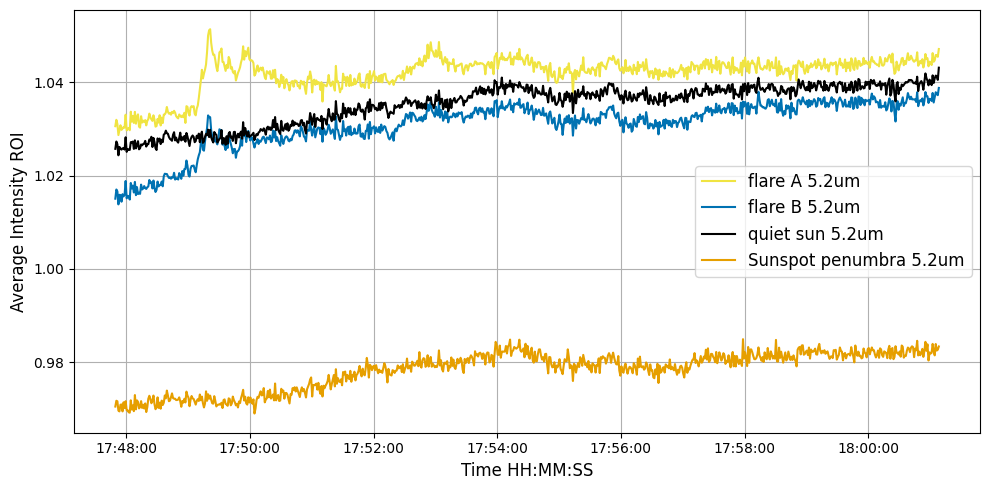

In [11]:
plt.figure(figsize=(10, 5))
plt.xlabel('Time HH:MM:SS',fontsize=12)
plt.ylabel('Average Intensity ROI',fontsize=12)

plt.plot(time_05, fA_I_05, color=palette[4], label='flare A 5.2um')
plt.plot(time_05, fB_I_05, color=palette[5], label='flare B 5.2um')
plt.plot(time_05, qs_I_05, color=palette[0], label='quiet sun 5.2um')
plt.plot(time_05, sp_I_05, color=palette[1], label='Sunspot penumbra 5.2um')


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=2))
plt.xticks(rotation=0)
plt.grid(True)
plt.legend(fontsize=12)#,loc='lower right')
plt.tight_layout()

plt.show()


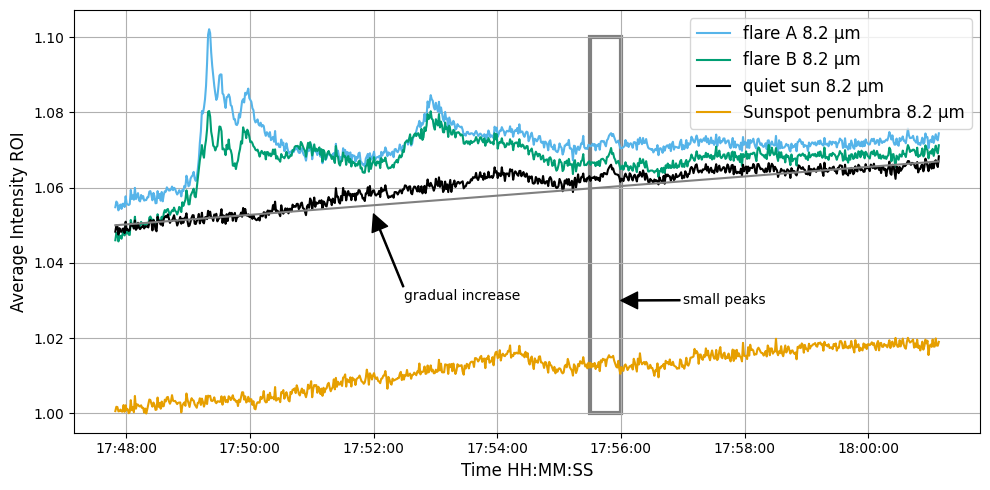

In [12]:
y=np.arange(0, len(time_10), 1)*((1.067-1.05)/len(time_10))+1.05 #Linear estimate of the  gradual increase in intensity.

plt.figure(figsize=(10, 5))
plt.xlabel('Time HH:MM:SS',fontsize=12)
plt.ylabel('Average Intensity ROI',fontsize=12)

plt.plot(time_10, fA_I_10, color=palette[2], label='flare A 8.2 µm')
plt.plot(time_10, fB_I_10, color=palette[3], label='flare B 8.2 µm')
plt.plot(time_10, qs_I_10, color=palette[0], label='quiet sun 8.2 µm')
plt.plot(time_10, sp_I_10, color=palette[1], label='Sunspot penumbra 8.2 µm')

plt.plot(time_10, y, 'grey')
plt.annotate('gradual increase', xy=(datetime(2014,9,24,17,52,00), 1.053), xytext=(datetime(2014,9,24,17,52,30), 1.03), arrowprops=dict(facecolor='k', width=0.8), size=10)
plt.gca().add_patch(Rectangle((datetime(2014,9,24,17,55,30), 1), datetime(2014,9,24,17,52,30)-datetime(2014,9,24,17,52,00),0.1, edgecolor = 'grey', facecolor = 'blue', fill=False, lw=3))
plt.annotate('small peaks', xy=(datetime(2014,9,24,17,56,00), 1.03), xytext=(datetime(2014,9,24,17,57,0), 1.029), arrowprops=dict(facecolor='k', width=0.8), size=10)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=2))
plt.xticks(rotation=0)
plt.grid(True)
plt.legend(fontsize=12,loc='upper right')
plt.tight_layout()


# Guardar imágenes
#plt.savefig(f"{folder}/img_paper_1/curva_intensidad.eps", format="eps", dpi=300)
#plt.savefig(r"C:\Users\migue\OneDrive - University of Glasgow\IR\img_paper_1\curva_intensidad.eps", format="eps", dpi=300)
#plt.savefig(r"C:\Users\migue\OneDrive - University of Glasgow\IR\img_paper_1\curva_intensidad.png", format="png", dpi=300)

plt.show()

GOES data

In [13]:
file_goes15 = f"{folder}/goes_data.nc"
goes_15 = ts.TimeSeries(file_goes15)

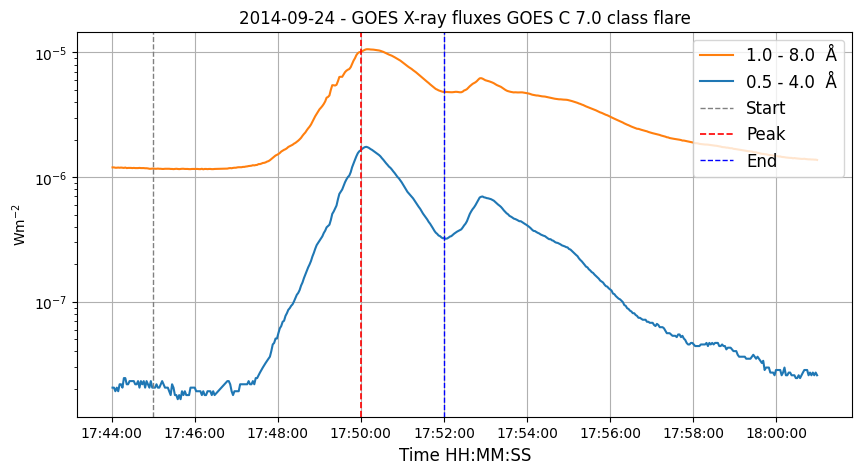

In [14]:
from datetime import datetime

df = goes_15.to_dataframe()
goes_15 = ts.TimeSeries(df, goes_15.meta, goes_15.units)

goes_flare = goes_15.truncate("2014-09-24 17:44", "2014-09-24 18:01")
time_support()

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("2014-09-24 - GOES X-ray fluxes GOES C 7.0 class flare")

ax.plot(goes_flare.time.datetime, goes_flare.quantity("xrsb"), label = "1.0 - 8.0  Å", color="C1")
ax.plot(goes_flare.time.datetime, goes_flare.quantity("xrsa"), label ="0.5 - 4.0  Å", color="C0")

ax.set_ylabel("Wm$^{-2}$")

# Líneas verticales
# Convertir cada Time a datetime compatible con matplotlib
from astropy.time import Time

start = Time('2014-09-24T17:45:00')
peak  = Time('2014-09-24T17:50:00')
end   = Time('2014-09-24T17:52:00')

ax.axvline(start.datetime, color="grey", linestyle="--", linewidth=1, label="Start")
ax.axvline(peak.datetime,  color="red",  linestyle="--", linewidth=1.2, label="Peak")
ax.axvline(end.datetime,   color="blue", linestyle="--", linewidth=1, label="End")

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=2))
ax.grid(True)

ax.legend(fontsize=12, loc='upper right')
ax.set_xlabel('Time HH:MM:SS', fontsize=12)
ax.set_yscale('log')

plt.show()


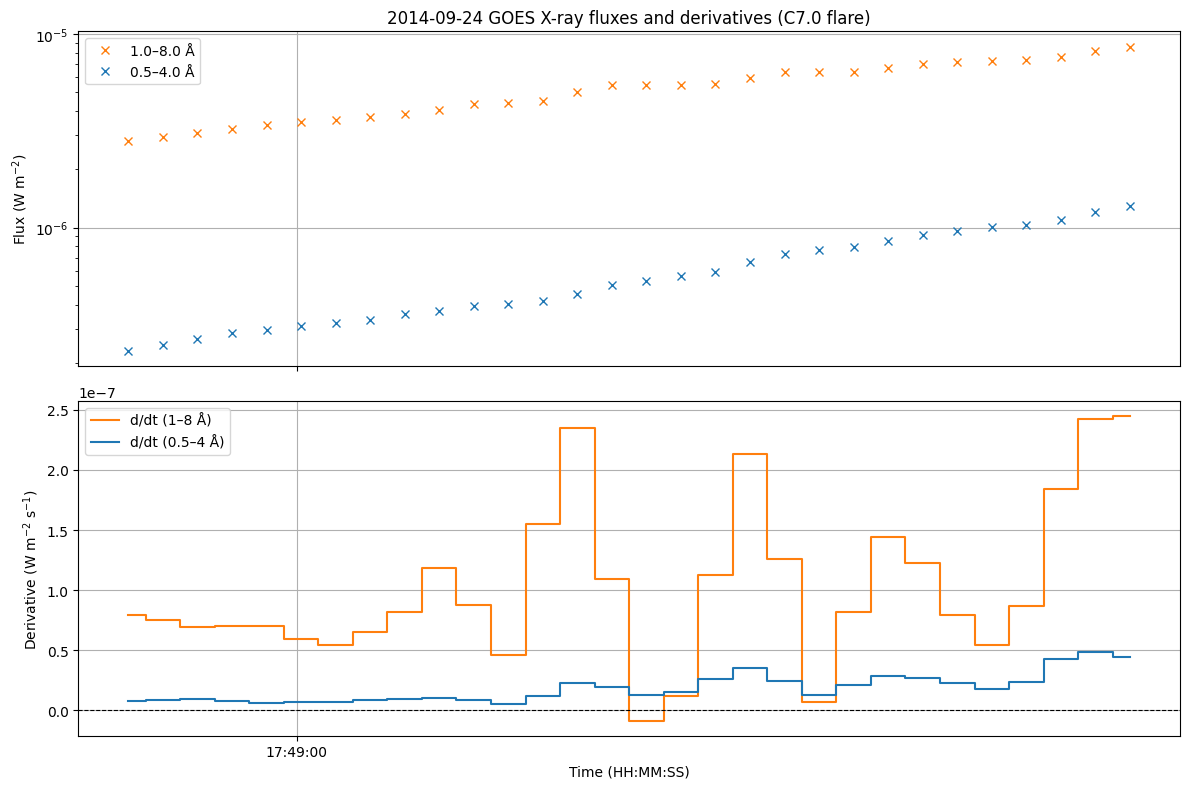

In [15]:

# --- DataFrame ---
df = goes_15.to_dataframe()
goes_15 = ts.TimeSeries(df, goes_15.meta, goes_15.units)

goes_flare = goes_15.truncate("2014-09-24 17:48:50", "2014-09-24 17:49:50")

# === Original Data ===
times = goes_flare.time.datetime
flux_a = goes_flare.quantity("xrsa").value   # 1-8 Å
flux_b = goes_flare.quantity("xrsb").value   # 0.5-4 Å

# === Derivatives ===
# convert datetime to seconds relative to t0
t_seconds = (times - times[0]).astype("timedelta64[s]").astype(float)

dflux_a = np.gradient(flux_a, t_seconds)  # d(flux)/dt
dflux_b = np.gradient(flux_b, t_seconds)
# Gradient in numpy uses: second-order accurate central difference

# === Plot ===
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Panel 1: Flux
ax1.set_title("2014-09-24 GOES X-ray fluxes and derivatives (C7.0 flare)")
ax1.plot(times, flux_b, 'x',label="1.0–8.0 Å", color="C1")
ax1.plot(times, flux_a,'x', label="0.5–4.0 Å", color="C0")
ax1.set_ylabel("Flux (W m$^{-2}$)")
ax1.set_yscale("log")
ax1.legend()
ax1.grid(True)

# Panel 2: Derivatives
ax2.step(times, dflux_b, where='mid', color="C1", label="d/dt (1–8 Å)")
ax2.step(times, dflux_a, where='mid', color="C0", label="d/dt (0.5–4 Å)")

ax2.axhline(0, color="k", linestyle="--", linewidth=0.8)
ax2.set_ylabel("Derivative (W m$^{-2}$ s$^{-1}$)")
ax2.legend()
ax2.grid(True)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax2.xaxis.set_major_locator(mdates.MinuteLocator(interval=2))
ax2.set_xlabel("Time (HH:MM:SS)")

plt.tight_layout()
plt.show()


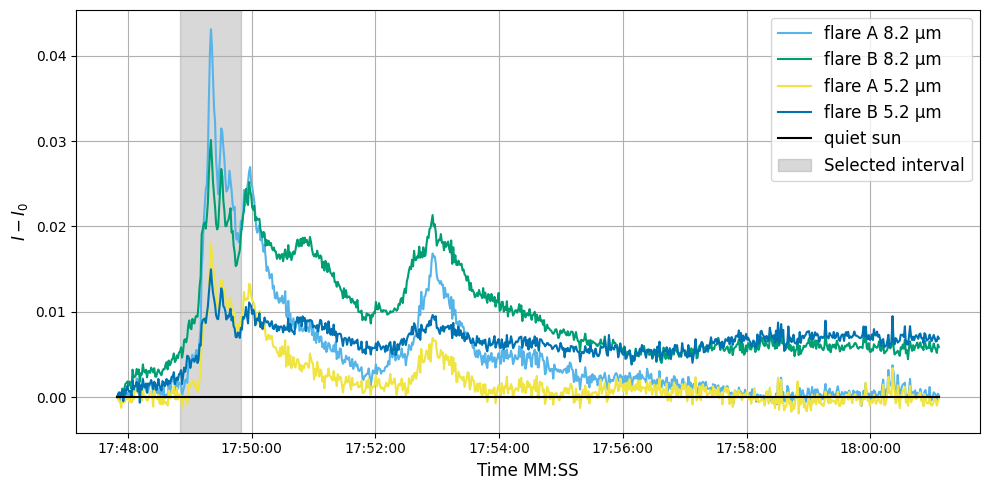

In [12]:
#Plots the intesity variation time series between two given times 8.2 um

t1=datetime(2014,9,24,17,47,0) #the initial date of the time series is 2014, 9, 24, 17, 47, 49, 483000
p_t1 = min(enumerate(time_10), key=lambda x: abs(x[1] - t1))[0] #find the position of the closer index given a date

t2=datetime(2014, 9, 24, 18, 1, 7, 483000) #the final date of the time series is 2014, 9, 24, 18, 1, 7, 483000
p_t2 = min(enumerate(time_10), key=lambda x: abs(x[1] - t2))[0] #find the position of the closer index given a date

# Tiempos de sombreado
t1_s = datetime(2014, 9, 24, 17, 48, 50)
t2_s = datetime(2014, 9, 24, 17, 49, 50)

plt.figure(figsize=(10, 5))
plt.xlabel('Time MM:SS', fontsize=12)
plt.ylabel(r'$I-I_0$', fontsize=12)

plt.plot(time_10[p_t1:p_t2], np.subtract(fA_I_10-fA_I_10[0], qs_I_10-qs_I_10[0])[p_t1:p_t2], color=palette[2], label='flare A 8.2 µm')
plt.plot(time_10[p_t1:p_t2], np.subtract(fB_I_10-fB_I_10[0], qs_I_10-qs_I_10[0])[p_t1:p_t2], color=palette[3], label='flare B 8.2 µm')
plt.plot(time_05[p_t1:p_t2], np.subtract(fA_I_05-fA_I_05[0],qs_I_05-qs_I_05[0])[p_t1:p_t2], color=palette[4], label='flare A 5.2 µm')
plt.plot(time_05[p_t1:p_t2], np.subtract(fB_I_05-fB_I_05[0],qs_I_05-qs_I_05[0])[p_t1:p_t2], color=palette[5], label='flare B 5.2 µm')
plt.plot(time_10[p_t1:p_t2], np.subtract(qs_I_10-qs_I_10[0], qs_I_10-qs_I_10[0])[p_t1:p_t2], color=palette[0], label='quiet sun')

# Shaded area 
plt.axvspan(t1_s, t2_s, color='gray', alpha=0.3, label='Selected interval')

# Formato del eje X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=2))
plt.xticks(rotation=0)

plt.grid(True)
plt.legend(fontsize=12, loc='upper right')
plt.tight_layout()

# Guardar
#plt.savefig(r"C:\Users\migue\OneDrive - University of Glasgow\IR\img_paper_1\curva_intensidad2.eps", format="eps", dpi=300)
#plt.savefig(r"C:\Users\migue\OneDrive - University of Glasgow\IR\img_paper_1\curva_intensidad2.png", format="png", dpi=300)

plt.show()


## ANALYSIS AND RESULTS ##

### Lag estimation using the Cross-correlation (CCF)) ###